In [1]:
import torch
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import numpy as np
from matplotlib import pyplot as plt
from tensorboardX import SummaryWriter

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

/home/rene/miniconda3/envs/tscl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_SIZE = (256, 256)
# CENTER_CROP = 150
GRAY = False

if GRAY:
    transform = transforms.Compose([
        transforms.resize(IMG_SIZE),
        transforms.Grayscale(),
        # transforms.CenterCrop(CENTER_CROP),
        transforms.ToTensor()
    ])
else:
    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        # transforms.CenterCrop(CENTER_CROP),
        transforms.ToTensor()
    ])

In [3]:
train_dataset = datasets.ImageFolder('./lfw', transform=transform)
train_dataset

Dataset ImageFolder
    Number of datapoints: 13233
    Root location: ./lfw
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

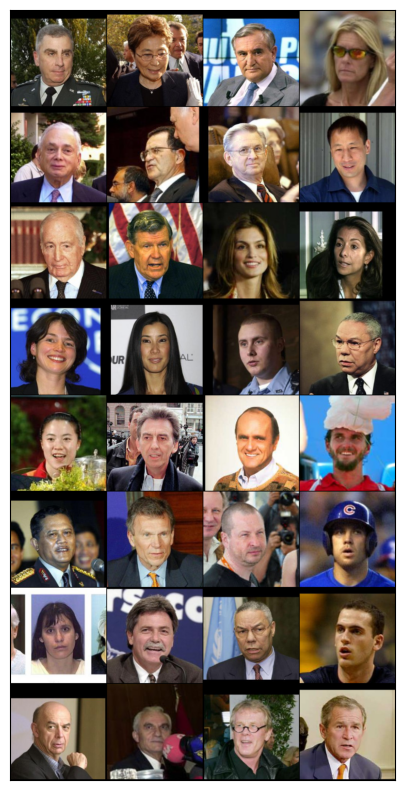

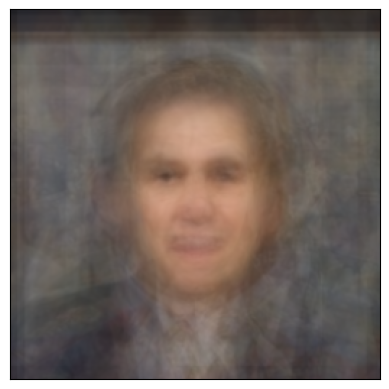

In [4]:
BATCH_SIZE = 32

g = torch.Generator()
g.manual_seed(SEED)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)

data, labels = next(iter(train_loader))

img_grid = utils.make_grid(data, nrow=4).numpy()
img_grid = np.transpose(img_grid, (1, 2, 0))

plt.figure(figsize= (10,10))
plt.imshow(img_grid)
plt.xticks([])
plt.yticks([])
plt.show()

mean = data.mean(axis=0)
mean_np = np.transpose(mean.numpy(), (1, 2, 0))
plt.imshow(mean_np)
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
from model import VAE

In [6]:
def kl_loss(mu, log_var):
    # TODO: dividir entre el numero de batches? 
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - torch.exp(log_var))

def r_loss(y_train, y_pred):
    r_loss = torch.mean((y_train - y_pred) ** 2)
    return r_loss



In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
INPUT_SHAPE = next(iter(train_loader))[0].shape[-3:]
Z_DIM = 256
ITERATION_COUNT = 200
SAMPLE_SIZE = 16
LR = .001
R_LOSS_FACTOR = 1000
EPOCHS = 10
VISUALIZE_EVERY = 200

writer = SummaryWriter(comment='-' + 'VAE-' + str(Z_DIM) + '-' + str(R_LOSS_FACTOR))

vae = VAE(INPUT_SHAPE, Z_DIM).to(device)
optimizer = optim.Adam(vae.parameters(), lr=LR)

latent_space_test_points = np.random.normal(scale=1.0, size=(SAMPLE_SIZE, Z_DIM))
latent_space_test_points_v = torch.Tensor(latent_space_test_points).to(device)

In [9]:
batch_iterations = 0
training_losses = []
vae.train()

for e in range(EPOCHS):
    epoch_loss = []
    epoch_batches = 0
    for images, labels in train_loader:
        images_v = images.to(device)

        optimizer.zero_grad()

        mu_v, log_var_v, images_out_v = vae(images_v)
        r_loss_v = r_loss(images_out_v, images_v)
        kl_loss_v = kl_loss(mu_v, log_var_v)
        loss = kl_loss_v + r_loss_v * R_LOSS_FACTOR
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

        if batch_iterations % VISUALIZE_EVERY == 0:
            # print loss
            print(f"Epoch: {e}\tBatch: {epoch_batches}\tLoss: {loss.item()}")
            writer.add_scalar('loss', np.mean(epoch_loss[-VISUALIZE_EVERY:]), batch_iterations)


        batch_iterations = batch_iterations + 1
        epoch_batches = epoch_batches + 1

    training_losses.append(np.mean(epoch_loss))
    if min(training_losses) == training_losses[-1]:
        vae.save('trained/vae-' + str(Z_DIM) + '-' + str(R_LOSS_FACTOR) + '.dat')

    vae.eval()

    generated_imgs_v = vae.forward_decoder(latent_space_test_points_v).detach()
    imgs_grid = utils.make_grid(generated_imgs_v)

    writer.add_image('preview-1', imgs_grid.cpu().numpy(), batch_iterations)

    vae.train()


Epoch: 0	Batch: 0	Loss: 116.19609069824219
Epoch: 0	Batch: 200	Loss: 35.391998291015625
Epoch: 0	Batch: 400	Loss: 39.79560089111328
Epoch: 1	Batch: 186	Loss: 38.86426544189453
Epoch: 1	Batch: 386	Loss: 32.532928466796875
Epoch: 2	Batch: 172	Loss: 29.237993240356445
Epoch: 2	Batch: 372	Loss: 32.913475036621094
Epoch: 3	Batch: 158	Loss: 27.39963150024414
Epoch: 3	Batch: 358	Loss: 28.113054275512695
Epoch: 4	Batch: 144	Loss: 28.17320442199707
Epoch: 4	Batch: 344	Loss: 31.69689178466797
Epoch: 5	Batch: 130	Loss: 29.705015182495117
Epoch: 5	Batch: 330	Loss: 27.095300674438477
Epoch: 6	Batch: 116	Loss: 29.36188507080078
Epoch: 6	Batch: 316	Loss: 25.51474380493164
Epoch: 7	Batch: 102	Loss: 24.52091407775879
Epoch: 7	Batch: 302	Loss: 23.0820369720459
Epoch: 8	Batch: 88	Loss: 25.9847354888916
Epoch: 8	Batch: 288	Loss: 22.926185607910156
Epoch: 9	Batch: 74	Loss: 25.51645278930664
Epoch: 9	Batch: 274	Loss: 24.157793045043945


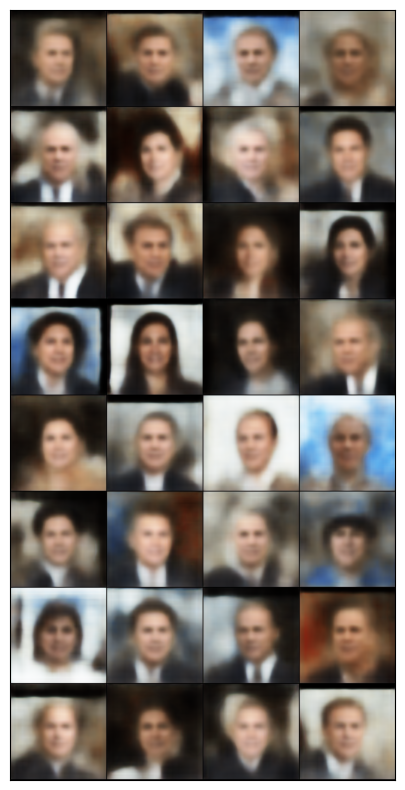

In [16]:
vae.eval()
data = data.cuda()
_, _, reconstructed_data =vae.forward(data)
reconstructed_data = reconstructed_data.detach().cpu()


img_grid = utils.make_grid(reconstructed_data, nrow=4).numpy()
img_grid = np.transpose(img_grid, (1, 2, 0))

plt.figure(figsize= (10,10))
plt.imshow(img_grid)
plt.xticks([])
plt.yticks([])
plt.show()